# CLV model

[Customer value in non-contractual business model](https://towardsdatascience.com/whats-a-customer-worth-8daf183f8a4f)

[lifetimes python package](https://github.com/CamDavidsonPilon/lifetimes) for modeling customer lifetime value (CVL). [Docs](https://lifetimes.readthedocs.io/en/latest/index.html).

[CLV in pyspark](http://webdropin.com/wordpress99/customer-lifetime-value-in-pyspark/)

[CLV broken down step-by-step](http://benalexkeen.com/bg-nbd-model-for-customer-base-analysis-in-python/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from lifetimes import BetaGeoFitter

from lifetimes.plotting import plot_frequency_recency_matrix

import helper as h

In [2]:
analysis_year = '2017'
user_data_2017 = h.get_merged_data(appName='CVL-model', year=analysis_year)
user_data_2017 = user_data_2017.select(user_data_2017.login,
                                       user_data_2017.first_event,
                                       user_data_2017.last_event,
                                       user_data_2017.frequency,
                                       user_data_2017.second_period_event_count)

% of users dropped 51.772519717725196


In [3]:
user_data_2016 = h.get_merged_data(appName='CVL-model', year='2016')
user_data_2016 = user_data_2016.select(user_data_2016.login, 
                                       user_data_2016.created_at)
user_data_2016 = user_data_2016.withColumnRenamed('login', 'login2016')
user_data_2016.head()

% of users dropped 4.698526359485271


Row(login2016='0loky0', created_at=datetime.datetime(2011, 5, 24, 16, 15, 25))

In [4]:
user_data = user_data_2017.join(user_data_2016,
                                user_data_2017['login'] == user_data_2016['login2016'],
                                how='right_outer')

In [5]:
user_data = user_data.toPandas()

In [6]:
user_data[['frequency', 'second_period_event_count']] = user_data[['frequency', 'second_period_event_count']].fillna(0)
user_data[['first_event', 'last_event']] = user_data[['first_event', 'last_event']].fillna("2016-01-01 01:01:01")

In [7]:
user_data = h.add_time_columns(user_data, end_date=analysis_year + '-06-01 23:59:59')

In [8]:
user_data.head()

,login,first_event,last_event,frequency,second_period_event_count,login2016,created_at,T,recency,time_between_first_last_event
0,0loky0,2017-02-09 03:01:26-06:00,2017-02-09 21:57:59-06:00,2.0,0.0,0loky0,2011-05-24 11:15:25-05:00,2200.0,2088.487894,0.789271
1,None,2015-12-31 19:01:01-06:00,2015-12-31 19:01:01-06:00,0.0,0.0,13246864965,2016-04-14 01:04:50-05:00,414.0,-104.210984,0.000000
2,1xPdd,2017-01-15 05:05:29-06:00,2017-05-31 18:39:40-05:00,19.0,13.0,1xPdd,2014-07-10 18:45:56-05:00,1057.0,1055.995648,136.523738
3,2582056905xy,2017-03-28 22:57:52-05:00,2017-05-21 22:46:50-05:00,7.0,16.0,2582056905xy,2014-04-24 05:51:26-05:00,1135.0,1123.705139,53.992338
4,None,2015-12-31 19:01:01-06:00,2015-12-31 19:01:01-06:00,0.0,0.0,277542952,2016-03-15 18:17:58-05:00,443.0,-74.928438,0.000000


### T, recency and frequency

Definitions from [lifetime](https://lifetimes.readthedocs.io/en/latest/Quickstart.html):

`frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

`T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

`recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

### Model CLV

In [9]:
n_weeks =  22 * 7

user_data['recency'] = np.floor(user_data.recency)
lifetime_df = user_data[['frequency', 'recency', 'T', 'login2016', 'second_period_event_count']]
# normalize frequency per week
#lifetime_df['frequency'] = lifetime_df.frequency / n_weeks
#lifetime_df['second_period_event_count'] = lifetime_df.second_period_event_count / n_weeks

lifetime_df = lifetime_df.dropna()

In [10]:
lifetime_df.head()

,frequency,recency,T,login2016,second_period_event_count
0,2.0,2088.0,2200.0,0loky0,0.0
1,0.0,-105.0,414.0,13246864965,0.0
2,19.0,1055.0,1057.0,1xPdd,13.0
3,7.0,1123.0,1135.0,2582056905xy,16.0
4,0.0,-75.0,443.0,277542952,0.0


In [11]:
lifetime_df = lifetime_df[(lifetime_df["T"] >= 0)]
lifetime_df['recency'][lifetime_df.frequency == 0] = 0
lifetime_df = lifetime_df[lifetime_df["recency"] >= 0]
#lifetime_df = lifetime_df[lifetime_df.frequency > 0]

In [12]:
lifetime_df.describe()

,frequency,recency,T,second_period_event_count
count,184642.000000,184642.000000,184642.000000,184642.000000
mean,15.351859,589.389126,1008.803436,13.169171
std,40.789337,779.815622,654.143989,40.521026
min,0.000000,0.000000,2.000000,0.000000
25%,0.000000,0.000000,464.000000,0.000000
50%,0.000000,0.000000,786.000000,0.000000
75%,11.000000,1074.000000,1419.000000,6.000000
max,597.000000,3399.000000,3410.000000,599.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d51b959e8>,
      dtype=object)

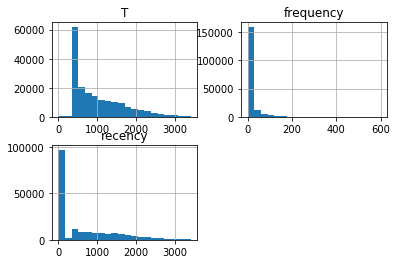

In [13]:
lifetime_df[['frequency', 'T', 'recency']].hist(bins=20)

In [14]:
# similar API to scikit-learn and lifelines.
n_users = 30000
lft_df = lifetime_df.sample(n=n_users, random_state=0)
bgf = BetaGeoFitter(penalizer_coef=1e-8)
bgf.fit(lft_df['frequency'], lft_df['recency'], lft_df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 30000 subjects, a: 0.07, alpha: 9.26, b: 182.50, r: 0.15>


In [15]:
# save the model
bgf.save_model('CLV.pkl')

/home/brian/anaconda3/lib/python3.7/site-packages/lifetimes/fitters/beta_geo_fitter.py:214: RuntimeWarning: overflow encountered in double_scalars
  ((alpha + T) / (alpha + recency)) ** (r + x)


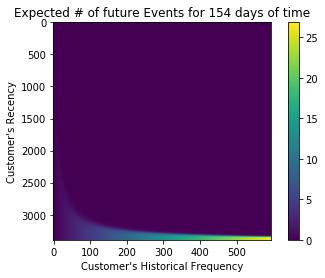

In [16]:
fig, ax = plt.subplots(1, 1)
ax = plot_frequency_recency_matrix(bgf, T=n_weeks, max_frequency=None, max_recency=None,
                             title='Expected # of future Events for {0} days of time'.format(n_weeks))
fig.savefig('figures/expected_number_events.png')

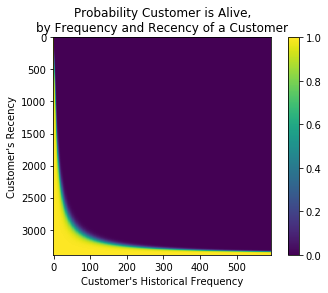

In [17]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

## Expected contributions in the upcoming cycle

In [18]:
lft_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(n_weeks,
                                                                                        lft_df['frequency'], 
                                                                                        lft_df['recency'], 
                                                                                        lft_df['T'])
lft_df.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,login2016,second_period_event_count,predicted_purchases
81599,327.0,384.0,386.0,milk-shake,69.0,126.380045
177053,548.0,594.0,595.0,abmorris,214.0,138.820091
151185,441.0,456.0,457.0,dengyuhan,447.0,144.599063
119611,496.0,476.0,476.0,bashkirtsevich,271.0,156.295166
132138,204.0,147.0,148.0,rasch,17.0,196.798336


[[1.        0.4910994]
 [0.4910994 1.       ]]


38.38407738512293

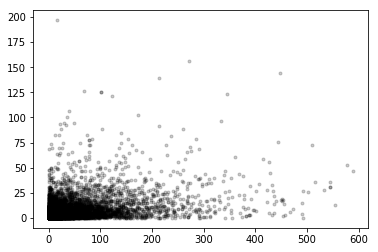

In [19]:
#user_data.dtypes
#predict_df = predict_df[predict_df.second_period_event_count < 60]
#lft_df['predicted_purchases'] = lft_df.predicted_purchases
plt.plot(lft_df.second_period_event_count, lft_df.predicted_purchases, 'k.', alpha=0.2)
#plt.xlim([0, 60])
#plt.ylim([0, 60])

print(np.corrcoef(lft_df.predicted_purchases, lft_df.second_period_event_count))
np.sqrt(np.mean((lft_df.predicted_purchases - lft_df.second_period_event_count) ** 2))

In [20]:
lft_df['probability_alive'] = bgf.conditional_probability_alive(1, lft_df['frequency'], 
                                                                  lft_df['recency'], n_weeks)
lft_df['alive'] = lft_df['probability_alive'] > 0.5
lft_df.head(15)

,frequency,recency,T,login2016,second_period_event_count,predicted_purchases,probability_alive,alive
93358,0.0,0.0,396.0,enanuxy,0.0,0.056532,0.999630,True
130457,16.0,1711.0,1745.0,vladimirivanoviliev,44.0,1.416616,0.954876,True
80468,0.0,0.0,2254.0,emfeha,0.0,0.010123,0.999630,True
157171,60.0,1318.0,1326.0,qule510,37.0,6.927641,0.989109,True
128463,91.0,2920.0,2932.0,subhash,69.0,4.767875,0.982440,True
163640,32.0,1909.0,1931.0,n0tnull,3.0,2.549460,0.970423,True
176393,0.0,0.0,396.0,izixoqi,0.0,0.056532,0.999630,True
62816,2.0,347.0,419.0,kacperrzepecki,2.0,0.772110,0.980787,True
75501,4.0,1440.0,1442.0,JulianKoenig,0.0,0.440042,0.924748,True
172646,0.0,0.0,567.0,fadindia,0.0,0.039757,0.999630,True


In [21]:
TP = np.sum((lft_df.alive == True) & (lft_df.second_period_event_count > 0))
FP = np.sum((lft_df.alive == False) & (lft_df.second_period_event_count > 0))
FN = np.sum((lft_df.alive == True) & (lft_df.second_period_event_count < 1))
TN = np.sum((lft_df.alive == False) & (lft_df.second_period_event_count < 1))

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + FN + TN)
f1score = 2 * (precision * recall) /  (precision + recall)
print('Precision: {0}'.format(np.round(precision, 3)))
print('Recall:    {0}'.format(np.round(recall, 3)))
print('Accuracy:  {0}'.format(np.round(accuracy, 3)))
print('F1-score:  {0}'.format(np.round(f1score, 4)))
#print([TP.sum(), FP.sum()])

Precision: 1.0
Recall:    0.366
Accuracy:  0.366
F1-score:  0.536


In [22]:
pd.DataFrame([lft_df.alive == True, lft_df.second_period_event_count > 0,
             (lft_df.alive == True) & (lft_df.second_period_event_count > 0)]).transpose()[:10]

,alive,second_period_event_count,Unnamed 0
93358,True,False,False
130457,True,True,True
80468,True,False,False
157171,True,True,True
128463,True,True,True
163640,True,True,True
176393,True,False,False
62816,True,True,True
75501,True,False,False
172646,True,False,False


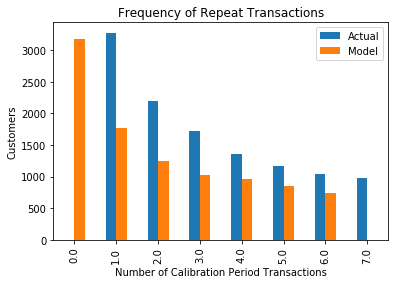

In [35]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)